In [51]:
import pickle
import sys
import pandas as pd
sys.path.insert(1, '../src')
import matplotlib.pyplot as plt
from character_utils import *
from IPython.display import HTML

# Predicting comic book character alignments from traits
This report presents the key exploratory data analysis, demonstrates the important statistical models used to predict the alignments (Good, Bad, or Neutral) of comic book characters. 

## Introduction

When you look at a new comic book character, do you naturally assume good or evil based on that character's traits? Are most of the characters with green faces, or red eyes likely to be evil? These questions lead us to think about how we can predict whether a character is good, bad or neutral. In this report, we are going to study some of the key features of [comic book characters](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters) from [Marvel Wikia](https://marvel.fandom.com/wiki/Marvel_Database) and [DC Wikia](https://dc.fandom.com/wiki/DC_Comics_Database), and construct statistical models to predict the character alignments.

## Research Question
>What are the most important features in determining a comic book characters' alignment?

## Data Overview

Each observation in the data set is a comic book character and their corresponding biographical features given in detail by the Table 1 below.

**Table 1: Dataset Feature Description**  

| Features   |      Definition      |Type|
|-----:-----|--:--|---:---|
| name |  The name of the character |categorical|
| id |   The identity status of the character (Secret Identity, Public identity, [on marvel only: No Dual Identity])  | categorical|
| align | If the character is Good, Bad or Neutral | target|
| eye | Eye color of the character | categorical|
| hair| Hair color of the character | categorical|
| sex | Sex of the character| categorical |
| gsm | If the character is a gender or sexual minority (e.g. Homosexual characters, bisexual characters) | categorical|
| appearances | The number of appareances of the character in comic books | numerical|
| first_appearance	| The month and year of the character's first appearance in a comic book, if available | categorical|
| year | The year of the character's first appearance in a comic book, if available | categorical, ordinal|
| publisher | The publisher of the character (dc or marvel in our case)|categorical|

#### How does character alignment change over time?



Figure 1 displays how character alignment changes over time. One observation is that all the alignments seem to move in the same direction as time passed, but to different extents. The majority of the characters created from 1935 to 2013 are villains for most years. Another interesting finding is that we have noticeable amount of null alignments in our data. It would be misleading to replace the missing values with any classes, and therefore, we decided to split those without alignments out as deployment data set. The alignments will then be predicted using our best selected model.

**Figure 1: Alignment of New Created Characters over Time**  

<img src="../results/figures/alignment_over_time.png" width="600" height="600" align="center"/>

#### Deal with missing values

Before applying any models to train these raw features, one essential step is to investigate whether our dataset contains features with a large proportion of missing values. Within the dataset, there are 13 different features and total 23,272 comic book characters. The percentage of missing cells is a bit high and around 21%. Since a considerable amount of the raw data contains missing values, this prompted a deeper investigation into each feature. Table 2 below describes the summary statistics for each one in the source data. After investigating the count of unique observations and missing value percentage for each feature, we decided to drop `gsm`(sexual minority) because it has the largest missing percentage which is around 99%. Furthermore, every observation in `name` feature is unique, therefore we introduced two additional features `first_name` and `last_name`, which are split from `name`. In other words, `name` feature will not be used directly as a categorical variable for analysis. Instead, we performed feature engineering to better utilize it, as described in the next section.

**Table 2: Dataset Feature Overview** 

<img src="../results/figures/feature_overview.png" width="600" height="240" align="center"/>

#### Feature Engineering

As briefly discussed above, the `name` variable is not an effective feature to train on because it contains excessive amount of unique observations. We decided to carry out feature engineering on it by referencing to the [Name Census: United States Demographic Data](https://namecensus.com). 

First, `is_common` feature is created by checking whether the first name of a character exists in the [Alphabetical List for Male Names](https://namecensus.com/male_names_alpha.htm) or the [Alphabetical List for Female Names](https://namecensus.com/female_names_alpha.htm) because we observed that an unusual name is a potential indicator for a bad (villain) character. Besides, many villains has long names and various do not have last name. Therefore, more features are created to better utilize the `name` variable. Finally, we introduced a normalizing way of representing the total number of appearance of each character.

The following table concludes our feature engineering outcomes. 

| New Features   |      Definition      |Type|
|-----:-----|--:--|---:---|
| is_common |  Whether the first name is common |boolean|
| name_len |  Number of characters in first and last name | numerical |
| has_last_name | Whether the character has a last name | boolean|
| appear_per_yr | The number of appearances per year since characters creation | numerical|

## Presenting and Interpreting Key Findings

**Table 3: Model Comparison Summary**  

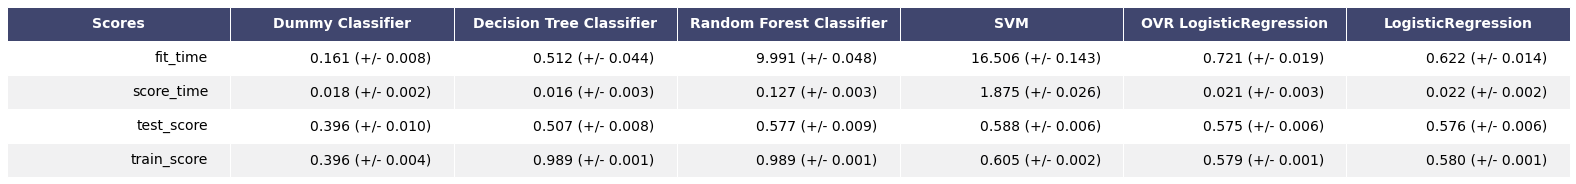

In [3]:
model_comparison_df = pickle.load(open("../results/tables/model_type_comparison.pkl", "rb"))
render_table(model_comparison_df, header_columns=0, col_width=4);

### Model Choice Overview

During the analysis phase, a number of different classification models were trained to predict the characters output alignment, and a model using the Random Forest Classification methodology was found to score the highest mean validation accuracy of .589 with over a 95% confidence interval compared to other model scores. Given this result, the RandomForestClassifier model will be the model chosen for further optimization through hyperparameter tuning.


### Feature Transformation and Encoding

To handle null feature values, we imputed the features with small null value proportions with the median for the numeric columns and the most frequent value for the categorical features. For the `gsm` and `first_appearance` features, we found that the data was too sparse to be of much value and decided to drop them to reduce unnecessary dimensions. The imputation step produced a higher validation accuracy score of approximately 1-2% across all models. This higher score was greater than 2 standard deviations of the test score for each trial (with imputed and with null), so we felt comfortable moving forward with imputed values as opposed to dropping null values for the columns chosen.

For the lone numerical feature, `appearances`, a scaler was applied to normalize the values.

The next steps to improve the model through feature transformation and encoding will be more aggressive feature engineering to create more powerful features. The key will be to use our intuition to use what we know of the comic book industry and cultural trends in general to select key features. Some areas of interest might be to transform `appearances` feature into a weighting modifier, and to bin the year values into discrete decades.


**Figure 4: Optimized Model Performance**  

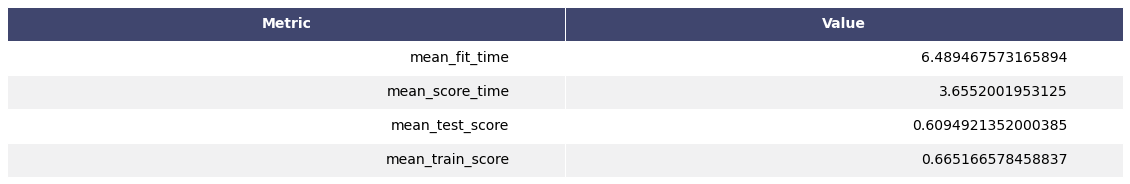

In [50]:
optimized_model_df = (pickle.load(open("../results/tables/optimized_model.pkl", "rb"))).loc[0, :]

pd.options.display.float_format = '{:.3f}'.format
rf_model = pd.DataFrame(optimized_model_df)
rf_model = rf_model[~rf_model.index.str.contains('split')].reset_index()
rf_model.columns = ["Metric", "Value"]
filter_list = ['mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score']
rf_model = rf_model[rf_model['Metric'].isin(filter_list)]
render_table(rf_model, header_columns=0, col_width=10);

## Optimized Model Performance

Figure 2 above reports the results obtained with the best model created to date. At the moment the optimized model use Random Forest Classification with an optimized hyperparameter `max_depth` value of $5.56\times10^7$ to predict the alignment of characters given their traits. The best model to date has a prediction accuracy of .589 in comparison to the baseline dummy classifier score of .391 using a most frequent target class value strategy. Further improvements to feature engineering, encoding, and hyperparameter optimization are necessary to improve model performance.

## Feature Importances

The ordered list of features with respect to importances for the best Random Forest Classifier model is found by fitting on `X_train` set. The numerical features are comparably important as indicated in the feature importance summary below. 



**Table 5: Feature Importance Summary** 

![image](../results/figures/importance.png)

From resulting importance coefficiens for `eye` feature, the most important eye colors are `Blue` and `Black` in determining the alignment of comic book characters. The whole ordered list can be found below.

From resulting importance coefficiens for `hair` feature, the most important hair colors is `Black` in determining the alignment of comic book characters. The whole ordered list can be found below.

**Table 6: Importance of Hair Feature** 

![image](../results/figures/importance_of_hair.png)

From resulting importance coefficiens for `id` (identity) feature, the most important identity is `Secret Identity` with distinct advantage to other classes in determining the alignment of comic book characters. The whole ordered list can be found below.

**Table 7: Importance of Identity Feature** 

![image](../results/figures/importance_of_id.png)

From resulting importance coefficiens for `sex` feature, there is not much of a difference between `Female` and `Male` characters importance in determining the alignment of comic book characters. The whole ordered list can be found below.

**Table 7: Importance of Sex Feature** 

![image](../results/figures/importance_of_sex.png)

From resulting importance coefficiens for `publisher` feature, there is not much of a difference between `dc` and `marvel`'s importance in determining the alignment of comic book characters. The whole ordered list can be found below.

**Table 8: Importance of Publisher Feature** 

![image](../results/figures/importance_of_publisher.png)

## Limitations

The limited number of features from the comic book character data set have so far not been as significant in predicting the character alignment as one might expect. One of the issues is the relative lack of feature diversity within the dataset as spelled out by the [original analysis article](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters). Because so many of the characters are so culturally homogenous the feature traits seem to map fairly evenly to all alignments.

## Future Directions
- Provide more descriptive EDA with greater resolution into how the character counts changes over time for each alignment by using stacked area chart as opposed to line chart. It will show us how the character count for each alignment changes compared to all characters.
- Feature engineering using human knowledge and intuition to create more powerful features. Use machine learning feature elimination techniques and reporting to determine how effective the features currently available are and provide a feedback mechanism to iteratively improve feature creation.
- With a model selected, hone in on more powerful (and time intensive) hyperparameter tuning techniques specific to the question and model at hand.
- Use a superior model on the test and deployment set to confirm results.

## References

1. [Comic Book Characters](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters) 
<!-- #endregion -->

2. [Sample Group Project](https://github.com/ttimbers/breast_cancer_predictor)

3. [Render Table Sample](https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure)

4. [Name Census: United States Demographic Data](https://namecensus.com)

Packages and dependencies:
- To reproduce, please see dependencies in [environment file](https://github.com/UBC-MDS/Workflows_showcase/blob/main/env/env.yaml).